<a href="https://colab.research.google.com/github/HyberionBrew/GTN/blob/main/GTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts
! pip install wandb
! pip install optuna

In [2]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy
import wandb
from pytorch_lightning.loggers import WandbLogger

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
NUM_WORKERS = int(os.cpu_count() / 2)
num_classes = 10

Global seed set to 7


In [3]:
!nvidia-smi

Fri May 20 17:24:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)
cifar10_dm.prepare_data()
cifar10_dm.setup()
print(len(cifar10_dm.train_dataloader()))

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:61: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:65: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:69: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:89: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:108: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."


157


In [5]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

In [6]:
wandb.login()

wandb: Currently logged in as: kressef (skylab). Use `wandb login --relogin` to force relogin


True

In [7]:
import torchvision.models as models
def create_model():
    model = models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

In [8]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        #cifar10_dm.prepare_data()
        #cifar10_dm.setup()
        steps_per_epoch = len(cifar10_dm.train_dataloader())
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


In [9]:
from torchsummary import summary
summary( create_model(), next(iter(cifar10_dm.val_dataloader()))[0][1].shape,device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
run = wandb.init(project="GTN", entity="skylab", reinit=True)

wandb: Currently logged in as: kressef (skylab). Use `wandb login --relogin` to force relogin


In [ ]:
wandb_logger = WandbLogger()

model = LitResnet(lr=0.05)
model.datamodule = cifar10_dm
trainer = Trainer(accelerator="gpu",
                     max_epochs=30,
                    logger=wandb_logger,    # W&B integration
                    log_every_n_steps=10,   # set the logging frequency
                    )
trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:89: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:108: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:127: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7."

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9221000075340271
        test_loss            0.279405802488327
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9221000075340271, 'test_loss': 0.279405802488327}]

In [146]:
run.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb3a580b710>> (for pre_run_cell):


Exception: ignored

Exception: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fb3a580b710>> (for post_run_cell):


Exception: ignored

Now lets run it with a GTN network!

In [36]:
# also called Generator in the paper
class Teacher(nn.Module):
    def __init__(self, z_dim = 128, num_classes=10, output_shape=(3,32,32), de_dim = 1024):
        super().__init__()
        self.fcs = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(z_dim+num_classes, 1024,bias=True),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.transConv = nn.Sequential(
            # 1024, 1
            nn.ConvTranspose2d(1024,de_dim//2,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 512 , 4
            nn.ConvTranspose2d(de_dim//2,de_dim//4,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 256, 8
            nn.ConvTranspose2d(de_dim//4,de_dim//8,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 128, 16
            nn.ConvTranspose2d(de_dim//8,32,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 32, 32
            nn.ConvTranspose2d(32,16,4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            # 8, 64
            nn.ConvTranspose2d(16,output_shape[0],4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, label):
        # input is gaussian noise and 
        x = torch.cat([noise,label],dim=1)
        x = self.fcs(x)
        x = x.view(x.shape[0],-1,1,1)
        x = self.transConv(x)
        output = nn.Upsample(size=(32, 32), mode='bilinear')(x)
        return output

In [37]:
num_classes = 10
def generate_noise(batch_size,z_dim):
    z = torch.normal(mean=torch.zeros(batch_size,z_dim), std=torch.ones(batch_size,z_dim))
    return z
def generate_ins(batch_size, z_dim, label):
    lab = torch.zeros(batch_size,num_classes)
    lab[:,label] = 1
    return generate_noise(batch_size,z_dim), lab

In [38]:
# test generator
ins = generate_ins(2,128, 1)
teacher_model = teacher(128)
outs = teacher_model(ins[0], ins[1])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


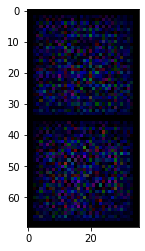

In [39]:
import matplotlib.pyplot as plt
grid_img = torchvision.utils.make_grid(outs, nrow=1)
plt.imshow(grid_img.permute(1, 2, 0))

In [48]:
# see if we can overfit the teacher to a single image
import torch.optim as optim
from tqdm import tqdm
data = next(iter(cifar10_dm.train_dataloader()))
data = data[0][0:2]
#data = data.unsqueeze(0)
criterion = nn.MSELoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9)
ins = generate_ins(2,128, 1)
running_loss = 0
epoch = 0
for i in tqdm(range(100)):
    # get the inputs; data is a list of [inputs, labels]
    inputs = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = teacher_model(ins[0],ins[1] )
    loss = criterion(outputs, data)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()

100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


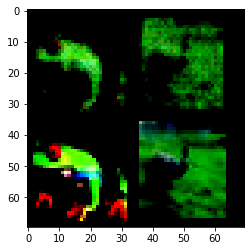

In [49]:
grid_img = torchvision.utils.make_grid(torch.cat([teacher_model(ins[0],ins[1]),data]), nrow=2)
plt.imshow(grid_img.permute(1, 2, 0))


Okay, the teacher model can learn. Debugging successful!

#Learner
The learner is the same model as the previous standard resnet-18.

In [50]:
class Learner(nn.Module):
    def __init__(self):
        self.learner = create_model()
    def forward(self):
        return self.learner

In [ ]:
class GTN(LightningModule):
    def __init__(self, latent_dim: int = 100, lr: float = 0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Teacher(latent_dim=self.hparams.latent_dim)
        self.learner = Learner()
    
    def forward(self,z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)


    def training_step(self, batch, batch_idx, optimizer_idx):
        pass
    
    def configure_optimizers(self):
        

In [ ]:
wandb.finish()